In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.impute import SimpleImputer
import datetime

# 1) Sarima Model Optimization

## 1.1) Cleaning the Data

### Historical Prices

In [44]:
prices_df = pd.read_csv('../data/bitcoinprice_api.csv')
prices_df.columns = ['date', 'price']
prices_df.date =  pd.to_datetime(prices_df.date)
#prices_df = prices_df.set_index('date')
prices_df = prices_df.drop_duplicates()

### Augmento Score

In [45]:
augmento_df = pd.read_csv('../data/augmento_scores_df.csv')
augmento_df = augmento_df.set_index('datetime')
augmento_df = augmento_df[['BTC_score','twitter_score','reddit_score']]
augmento_df['twitter_score'] = augmento_df['twitter_score'].replace(np.nan, np.mean(augmento_df['twitter_score']))

### Greed Score

In [53]:
greed_df = pd.read_csv('../data/Fear_Greed_df.csv')
greed_df.timestamp = pd.to_datetime(greed_df.timestamp)
greed_df = greed_df.sort_values(by='timestamp')
greed_df.columns = ['date','Fear&Greed']
#greed_df = greed_df.set_index('date')

In [54]:
prices_greed_df = pd.merge(prices_df,greed_df,on='date')

### Saving clean DF

In [125]:
model_df = pd.merge(prices_df,sentiment_df, left_index=True, right_index=True)
#model_df.to_csv('../data/prices_scores_clean.csv')

In [57]:
prices_greed_df = pd.merge(prices_df,greed_df,on='date')
prices_greed_df = prices_greed_df.set_index('date')
#prices_greed_df.to_csv('../data/prices_greed_score_clean.csv')

In [58]:
prices_greed_df

,price,Fear&Greed
date,,
2018-02-01,9052.5763,30
2018-02-02,8827.6300,15
2018-02-03,9224.3913,40
2018-02-04,8186.6488,24
2018-02-05,6914.2600,11
...,...,...
2021-02-25,47104.7833,79
2021-02-26,46329.7400,55
2021-02-27,46189.3783,56


### Retrieving DF from folder

In [219]:
model_df = pd.read_csv('../data/prices_scores_clean.csv')
model_df.columns = ['date', 'price', 'BTC_score','twitter_score','reddit_score']
model_df['date'] = pd.to_datetime(model_df['date'])
model_df = model_df.set_index('date')

In [51]:
prices_greed_df = pd.read_csv('../data/prices_greed_score_clean.csv')

In [52]:
prices_greed_df

,Unnamed: 0,date,price,Fear&Greed
0,0,2018-02-01,9052.5763,30
1,1,2018-02-02,8827.6300,15
2,2,2018-02-03,9224.3913,40
3,3,2018-02-04,8186.6488,24
4,4,2018-02-05,6914.2600,11
...,...,...,...,...
1117,1117,2021-02-25,47104.7833,79
1118,1118,2021-02-26,46329.7400,55
1119,1119,2021-02-27,46189.3783,56
1120,1120,2021-02-28,45256.4133,55


In [220]:
model_df.index.dtype

dtype('<M8[ns]')

<AxesSubplot:xlabel='date'>

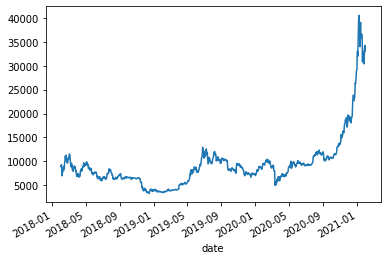

In [221]:
model_df['price'].plot()

### Train Test Split

In [305]:
train_df = model_df.loc[:'2021-01-10']
test_df = model_df.loc['2021-01-11':]

## 1.2) Viualizing Price Fluctuation and Score Fluctuation

<AxesSubplot:xlabel='date'>

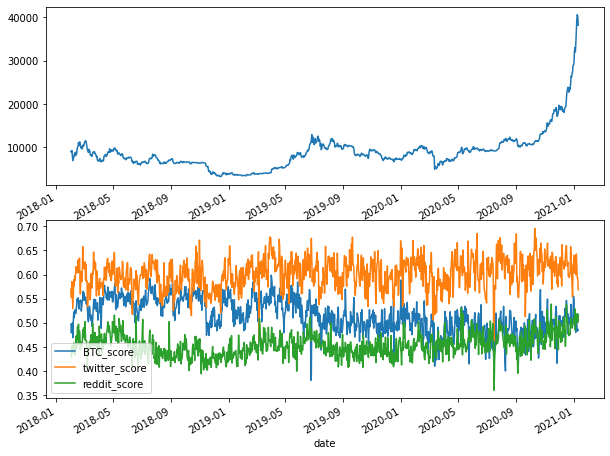

In [306]:
fig, ax = plt.subplots(2, 1, figsize=(10,8))
train_df['price'].plot(ax = ax[0])
train_df[['BTC_score','twitter_score','reddit_score']].plot(ax = ax[1])

## 1.3) AD Fuller Test

In [307]:
result_0 = adfuller(train_df['price'])
result_1 = adfuller(train_df['price'].diff(1).dropna())
result_2 = adfuller(train_df['price'].diff(1).diff(1).dropna())
print (f"diff = 0: p_value = {result_0[1]}")
print (f"diff = 1: p_value = {result_1[1]}")
print (f"diff = 2: p_value = {result_2[1]}")

diff = 0: p_value = 1.0
diff = 1: p_value = 0.23151560087916623
diff = 2: p_value = 2.873984723140382e-25


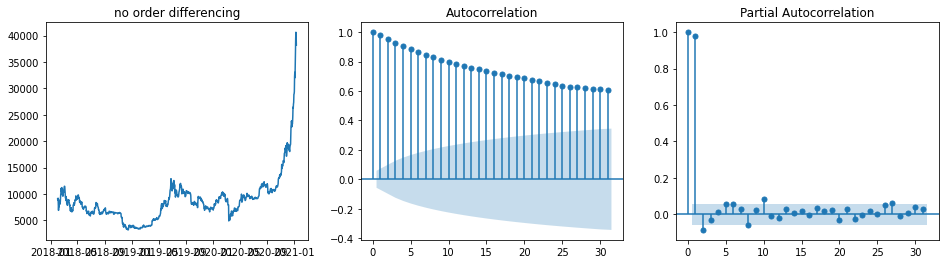

In [308]:
fig, ax = plt.subplots(1,3, figsize=(16,4))
ax[0].plot(train_df['price']); ax[0].set_title('no order differencing')
plot_acf(train_df['price'], ax=ax[1])
plot_pacf(train_df['price'], ax=ax[2])
plt.show()

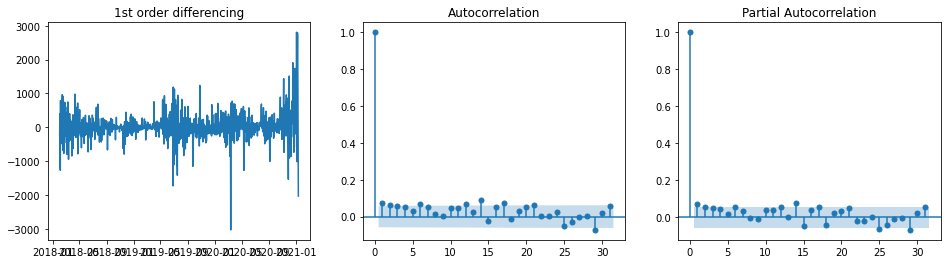

In [309]:
fig, ax = plt.subplots(1,3, figsize=(16,4))
ax[0].plot(train_df['price'].diff(1).dropna()); ax[0].set_title('1st order differencing')
plot_acf(train_df['price'].diff(1).dropna(), ax=ax[1])
plot_pacf(train_df['price'].diff(1).dropna(), ax=ax[2])
plt.show()

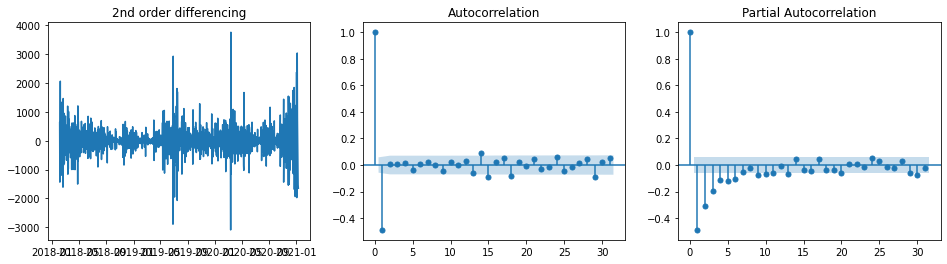

In [310]:
fig, ax = plt.subplots(1,3, figsize=(16,4))
ax[0].plot(train_df['price'].diff(1).diff(1).dropna()); ax[0].set_title('2nd order differencing')
plot_acf(train_df['price'].diff(1).diff(1).dropna(), ax=ax[1])
plot_pacf(train_df['price'].diff(1).diff(1).dropna(), ax=ax[2])
plt.show()

## Arima Model 

In [311]:
sarimax = SARIMAX(train_df['price'], order=(1,1,1), exog=train_df['BTC_score'])

/Users/yassine_rkaibi/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/yassine_rkaibi/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [312]:
results = sarimax.fit()

/Users/yassine_rkaibi/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [328]:
predictions = results.get_forecast(steps=len(test_df),exog=test_df['BTC_score']).predicted_mean

/Users/yassine_rkaibi/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [329]:
predictions

1149    38470.435516
1150    38898.504952
1151    39426.028409
1152    39967.022959
1153    40365.090704
1154    40747.349074
1155    41051.117149
1156    41561.157309
1157    42100.222882
1158    42419.350937
1159    42749.713250
1160    43135.797871
1161    43485.753286
1162    43832.855545
1163    44335.564420
1164    44783.373430
1165    45071.148896
1166    45484.985348
1167    45984.168727
1168    46337.502917
1169    46695.876059
dtype: float64

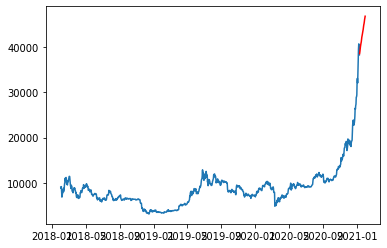

In [333]:
plt.plot(train_df['price'])
plt.plot(test_df.index, predictions, color='r')

In [295]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  price   No. Observations:                 1170
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -8779.133
Date:                Wed, 03 Mar 2021   AIC                          17566.267
Time:                        15:37:32   BIC                          17586.522
Sample:                             0   HQIC                         17573.907
                               - 1170                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
BTC_score   4096.6457    464.359      8.822      0.000    3186.519    5006.772
ar.L1          0.0041      1.523      0.003      0.998      -2.981       2.989
ma.L1          0.0040      1.526      0.003      0.998      -2.987       2.995
sigma2      1.935e+05   2541.987     76.105      0.000    1.88e+05    1.98e+05
===================================================================================
Ljung-Box (Q):                      128.42   Jarque-Bera (JB):             23344.44
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.01   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [296]:
results.get_forecast

<bound method MLEResults.get_forecast of <statsmodels.tsa.statespace.sarimax.SARIMAXResults object at 0x1317c54c0>>